**IMPORT LIBRARIES**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import re
import ast
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


**LOAD THE DATA**

In [4]:
movies_df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  
pd.set_option('display.max_columns', None)
ratings = pd.read_csv('../../edit_data/Chan/source_data/ratings_small.csv')


In [5]:
movies_df.head(2)

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']


In [58]:
movies_df["Cast_parse"].head(2)

0    [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
1    [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
Name: Cast_parse, dtype: object

**PREDICTION MODEL BASED ON POPULARITY AND ACTORS**

In [104]:
# Ensure 'Cast_parse' is in list format and handle any non-list or NaN entries
movies_df['Cast_parse'] = movies_df['Cast_parse'].apply(lambda x: eval(x) if isinstance(x, str) else x if isinstance(x, list) else [])

# Prompting the user to input an actor's name
actor_name = input("Enter the actor's name: ").strip().lower()

# Filtering movies based on the actor's name
filtered_movies = movies_df[movies_df['Cast_parse'].apply(lambda cast: any(actor_name == actor.lower().strip() for actor in cast))]

# Check if any movies match the actor
if filtered_movies.empty:
    print(f"No movies found with actor {actor_name}.")
else:
    # Sorting the filtered movies based on the 'Popularity' column in descending order
    filtered_movies_sorted = filtered_movies.sort_values(by='Popularity', ascending=False)

    # Selecting the top 5 movies
    top_5_filtered_movies = filtered_movies_sorted.head(5)

    # Formatting the output to look prettier
    print("\nTop 5 Movies featuring actor '{}':\n".format(actor_name.title()))
    for i, row in top_5_filtered_movies.iterrows():
        print(f"Title: {row['Original_Title']}")
        print(f"Vote Average: {row['Vote_Average']}")
        print(f"Popularity: {row['Popularity']}")
        print(f"Cast: {', '.join(row['Cast_parse'])}")
        print("-" * 50)  # Separator line for clarity



Top 5 Movies featuring actor 'Dwayne Johnson':

Title: The Fate of the Furious
Vote Average: 6.8
Popularity: 48.573287
Cast: Vin Diesel, Jason Statham, Dwayne Johnson, Michelle Rodriguez, Tyrese Gibson, Ludacris, Charlize Theron, Kurt Russell, Nathalie Emmanuel, Luke Evans, Elsa Pataky, Kristofer Hivju, Scott Eastwood, Corey Maher, Tego Calderón, Don Omar, Helen Mirren, Patrick St. Esprit, Eden Estrella, Janmarco Santiago, Luke Hawx, Celestino Cornielle, Olek Krupa, Alexander Babara, Andre Pushkin, Robert Jekabson, Nick Gracer, Gary Weeks, Michael W. Broomer, Theresa Cook, Kim Evans, Oleg Prudius, Connie Kincer, Yassie Hawkes, Destiny Lopez, Anita Farmer Bergman, Friday Chamberlain, Mya Levels, Yuliya Zelenskaya, Trevor Wolf, Megan Marie Wilson, Myrom Kingery, Dominick Wilkins, Shannon Marie Watts, Gary Lee Vincent, Zachary Vazquez, Ronald Joe Vasquez, Alan Tuskes, Mikhail Tot, Branislav R. Tatalovic, Doug Stroup, Eddy Stewart, Shawn Sterba, Nancy Ellen Shore, Jon Komp Shin, Darren Sh

**KNN MODEL**

*TfidfVectorizer*: This is a tool from **sklearn** used for converting text data into numerical features. It transforms the textual information in the movie descriptions into a form that can be used by machine learning models.


*NearestNeighbors*: This is an algorithm from **sklearn** that helps in finding the nearest points (in this case, movies) based on some measure of distance. We use this for recommending similar movies.


Purpose: Movies have multiple text features (e.g., tagline, overview, and keywords) that describe them. To make the recommendation system more accurate, we combine these features into a single string that describes each movie.


In [8]:
# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with additional details
def get_movie_recommendations(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    # Find the index of the input movie
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    # Get the distances and indices of the nearest neighbors
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    # Get the indices of the top 5 similar movies (excluding the input movie itself)
    similar_movies_indices = indices.flatten()[1:]
    
    # Fetch the details of the similar movies
    similar_movies = data.iloc[similar_movies_indices][['Original_Title', 'Popularity', 'Vote_Average', 'Original_Language']]
    
    return similar_movies

# Prompt the user for a movie title
user_input_movie = input("Enter a movie title: ")

# Get recommendations based on user input
recommendations = get_movie_recommendations(user_input_movie)

# Display the recommendations with additional details
if isinstance(recommendations, str):
    print(recommendations)
else:
    print("\nUser's Input: {}".format(user_input_movie))
    print("\nTop 5 movies similar to {}: \n".format(user_input_movie))
    for i, row in recommendations.iterrows():
        print("{}. {} (Popularity: {}, Rating: {}, Language: {})".format(i+1, row['Original_Title'], row['Popularity'], row['Vote_Average'], row['Original_Language']))



User's Input: batman

Top 5 movies similar to batman: 

9183. Batman Beyond: Return of the Joker (Popularity: 7.872438, Rating: 7.5, Language: en)
1484. Batman & Robin (Popularity: 17.038824, Rating: 4.2, Language: en)
40976. LEGO DC Comics Super Heroes: Justice League - Gotham City Breakout (Popularity: 3.581416, Rating: 7.0, Language: en)
21239. Batman: Mystery of the Batwoman (Popularity: 8.26786, Rating: 6.6, Language: en)
10071. Batman Begins (Popularity: 28.505341, Rating: 7.5, Language: en)


**WITH SIMILARITY SCORE**

**How Similarity Score is Calculated**

Movies similar to 'back to the future':
                    Original_Title  Similarity_Score
1891    Back to the Future Part II          0.321666
1892   Back to the Future Part III          0.251560
43167                 Time Chasers          0.169823
5017              The Time Machine          0.160073
26410                    P.U.N.K.S          0.159954


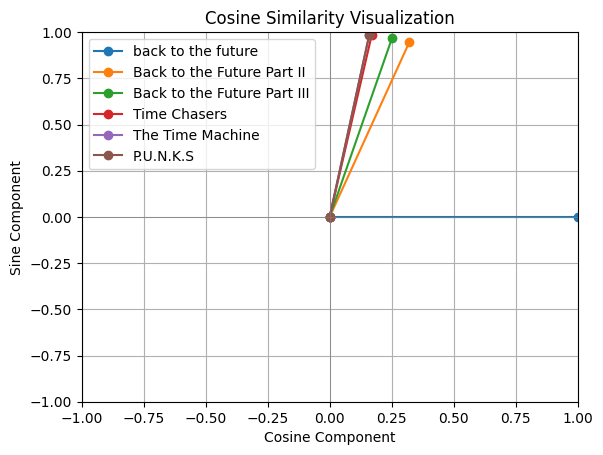

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with similarity scores
def get_movie_recommendations_with_similarity(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    similar_movies_indices = indices.flatten()[1:]
    similar_movies_distances = distances.flatten()[1:]
    
    similarity_scores = 1 - similar_movies_distances
    
    similar_movies = data.iloc[similar_movies_indices][['Original_Title']]
    similar_movies['Similarity_Score'] = similarity_scores
    
    return similar_movies

# Function to plot cosine similarity visualization
def plot_cosine_similarity(movie_title, recommendations_df):
    fig, ax = plt.subplots()
    
    base_similarity = 1.0
    movies = [movie_title] + recommendations_df['Original_Title'].tolist()
    similarities = [base_similarity] + recommendations_df['Similarity_Score'].tolist()
    
    angles = np.arccos(similarities)
    
    for i, angle in enumerate(angles):
        x = np.cos(angle)
        y = np.sin(angle)
        ax.plot([0, x], [0, y], label=movies[i], marker='o')
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Cosine Component')
    ax.set_ylabel('Sine Component')
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)
    
    ax.set_title('Cosine Similarity Visualization')
    ax.legend()
    
    plt.grid(True)
    plt.show()

# Example usage
user_input_movie = input("Enter a movie title: ")

recommendations = get_movie_recommendations_with_similarity(user_input_movie)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"Movies similar to '{user_input_movie}':")
    print(recommendations)
    plot_cosine_similarity(user_input_movie, recommendations)
